## ML MIPT Practical 3

В данном домашнем задании вы будете решать задачу классификации отзывов.

Шаги решения:

1. Извлечение признаков: напишите код для создания TF-IDF матрицы из представленного корпуса отзывов
2. Обучение моделей: напишите код для обучения SVM и логистической регрессии
3. Кросс-валидация для подбора гиперпараметров: напишите код для оптимизации метрик обучения
4. Участие в контесте на kaggle.com

In [1]:
import pandas as pd
import random
import numpy as np
import time
#import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#%matplotlib inline
#plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
#plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['image.cmap'] = 'gray'

# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

-------
#### Знакомство с данными

In [2]:
data = pd.read_csv('train.scv', index_col=0, na_values='NaN')
print data.shape
print data.head()

(352278, 2)
                                          Reviews_Summary  Prediction
ID                                                                   
230872                                  Babies love these           3
344823                                       Salmon Trout           0
211754                                     disappointment           1
259421  Doesn't taste like Cinnabon; tastes like Waffl...           2
253418  Delicious San Daniele prosciutto and good cust...           3


In [3]:
data.Reviews_Summary.values, data.Prediction.unique()

(array(['Babies love these', 'Salmon Trout', 'disappointment', ...,
        'quite good', 'Great yummy treat for my little ones', 'Disappointed'], dtype=object),
 array([3, 0, 1, 2]))

Как видите, каждый объект представляет собой отзыв о продукте и оценку по шкале от 0 до 3. Выдвинем гипотезу, что слова, используемые в написании отзыва коррелируют с оценкой, которая была поставлена. Поставим задачу - предсказать оценку, по тексту отзыва.

-----
### 1. Извлечение признаков - 10 Баллов
 

1. Для решения задачи классификации необходимо преобразовать каждый отзыв (документ) в вектор. Размерность данного вектора будет равна количеству слов используемых в корпусе (все документы). Каждая координата соответствует слову, значение в координает равно количеству раз, слово используется в документе. 

Для решения данной задачи вам необходимо написать код, который преобразовывает матрицу документов в численную матрицу.

Дополнительная информация для решения задачи:

- Подробнее про векторное представление документов: http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
- Используйте данный трансформер: http://scikit-learn.org/stable/modules/feature_extraction.html#common-vectorizer-usage
- Подробнее про разреженные матрицы: http://docs.scipy.org/doc/scipy-0.14.0/reference/sparse.html
- Hashing trick: https://en.wikipedia.org/wiki/Feature_hashing

Используйте n_features = 3000

In [4]:
corpus = data.Reviews_Summary.values
corpus

array(['Babies love these', 'Salmon Trout', 'disappointment', ...,
       'quite good', 'Great yummy treat for my little ones', 'Disappointed'], dtype=object)

In [5]:
vectorizer = CountVectorizer(min_df=1, max_features=3000)
X = vectorizer.fit_transform(corpus)

In [6]:
X.shape

(352278, 3000)

Для учета важности редких, но показательных слов (термов), используется схема взвешивания TF-IDF. Напишите код, принимающий на вход разреженную матрицу векторного представления документов и возвращающий разреженную матрицу документов, частоты термов которых взвешенны по TF-IDF.

Дополнительная информация для решения задачи:

- Подробнее про TF-IDF: https://en.wikipedia.org/wiki/Tf%E2%80%93idf
- Используйте трансформер: http://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting

In [7]:
transformer = TfidfTransformer(norm='l2')
X = transformer.fit_transform(X)

In [8]:
X = X.toarray()

In [9]:
Y = data.Prediction.values

------

### 2. Код для SVM и логистической регресии - 40 Баллов

После того, как вы получили матрицу признаков, вам необходимо реализовать алгоритм обучения SVM и логистической регрессии. Обе модели являются линейными и отличаются функциями потерь. Для решения оптимизационных задач в обеих моделей будет использоваться стохастический градиентный спуск.

Дополнительная информация для решения задачи:

- Линейные модели: http://cs231n.github.io/linear-classify/
- SGD: http://cs231n.github.io/optimization-1

Начнем с SVM стартовый код находится в файле cs231n/classifiers/linear_svm.py вашей задачей является реализация подсчета функции потерь для SVM

Разбейте обучающую выборку на 2 части train и test

Дополнительная информация для решения задачи:
- Используйте трансформер: http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html#sklearn.cross_validation.train_test_split

In [10]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

Транспонируем матрицы с данными, т.к. так будет проще реализовать код SVM

In [11]:
X_train, X_test = X_train.T, X_test.T

Возьмем подвыборки из обучающей выборки, для быстрой проверки кода.

In [12]:
train_size = 100000
X_train_sample = X_train[:, :train_size]
y_train_sample = y_train[:train_size]

In [13]:
X_train_sample.shape

(3000, 100000)

Найдем чему равен градиент:

In [20]:
from cs231n.classifiers.linear_svm import svm_loss_naive, svm_loss_vectorized

# generate a random SVM weight matrix of small numbers
W = np.random.randn(4, X_train_sample.shape[0]) * 0.01 
%time loss, grad = svm_loss_naive(W, X_train_sample, y_train_sample, 0.00001)
print 'loss: %f' % (loss, )

CPU times: user 4.78 s, sys: 67.8 ms, total: 4.85 s
Wall time: 2.32 s
loss: 2.999401


Градиент равен 0, т.к. код который должен его считать отсутствует. Реализуйте наивную версию и проверьте результат с помощью численного метода расчета. Градиенты должны почти совпадать.

In [21]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_train_sample, y_train_sample, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_train_sample, y_train_sample, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 5)

numerical: 0.000048 analytic: 0.000048, relative error: 8.401037e-08
numerical: 0.000031 analytic: 0.000031, relative error: 6.331158e-07
numerical: 0.004454 analytic: 0.004454, relative error: 6.072872e-08
numerical: -0.000405 analytic: -0.000405, relative error: 7.947509e-08
numerical: -0.000024 analytic: -0.000024, relative error: 1.083355e-06


Завершите реализацию SVM, реализуйте векторизированную версию расчета градиента.

In [22]:
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print 'Naive loss and gradient: computed in %fs' % (toc - tic)

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print 'Vectorized loss and gradient: computed in %fs' % (toc - tic)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'difference: %f' % difference

Naive loss and gradient: computed in 2.346205s
Vectorized loss and gradient: computed in 0.313998s
difference: 0.000011


### Stochastic Gradient Descent

In [26]:
# Now implement SGD in LinearSVM.train() function and run it with the code below
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=5e-2, reg=0.01,
                      num_iters=500, verbose=True, batch_size=20000)

toc = time.time()
print 'That took %fs' % (toc - tic)
print 'Current loss is %f' % loss_hist[-1]

iteration 0 / 500: loss 3.000025
iteration 100 / 500: loss 2.604984
iteration 200 / 500: loss 2.266889
iteration 300 / 500: loss 2.034435
iteration 400 / 500: loss 1.891755
That took 106.970655s
Current loss is 1.783438


In [30]:
# Write the LinearSVM.predict function 
y_train_pred = svm.predict(X_train)
y_test_pred = svm.predict(X_test)

In [31]:
#and evaluate the performance on both the test set
from sklearn.metrics import classification_report

In [32]:
print classification_report(y_test, y_test_pred)

             precision    recall  f1-score   support

          0       0.45      0.23      0.30     11476
          1       0.67      0.02      0.04      6605
          2       0.42      0.01      0.02     17838
          3       0.72      0.98      0.83     80333

avg / total       0.64      0.70      0.61    116252



In [33]:
# compare result with the most common dummy classifier
print classification_report(y_test, [3]*len(y_test))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00     11476
          1       0.00      0.00      0.00      6605
          2       0.00      0.00      0.00     17838
          3       0.69      1.00      0.82     80333

avg / total       0.48      0.69      0.56    116252



/home/ubuntu/anaconda2/envs/venv/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------

## Softmax Classifier

In [34]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(4, X_train_sample.shape[0]) * 0.01 
loss, grad = softmax_loss_naive(W, X_train_sample, y_train_sample, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 1.386788
sanity check: 2.302585


In [35]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_train_sample, y_train_sample, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_train_sample, y_train_sample, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 5)

numerical: 0.000010 analytic: 0.000010, relative error: 4.437077e-07
numerical: 0.000041 analytic: 0.000041, relative error: 1.941184e-08
numerical: 0.000040 analytic: 0.000040, relative error: 1.147942e-06
numerical: -0.000175 analytic: -0.000175, relative error: 8.383948e-08
numerical: 0.000004 analytic: 0.000004, relative error: 2.177785e-06


In [36]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)
# print type(loss_vectorized)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 1.386800e+00 computed in 4.526186s
vectorized loss: 1.386800e+00 computed in 0.231330s
Loss difference: 0.000000
Gradient difference: 0.000000


In [13]:
from cs231n.classifiers import Softmax
sm = Softmax()
tic = time.time()
loss_hist = sm.train(X_train, y_train, learning_rate=5e-3, reg=0.01,
                      num_iters=1000, verbose=True, batch_size=2000)

toc = time.time()
print 'That took %fs' % (toc - tic)
print 'Current loss is %f' % loss_hist[-1]

iteration 0 / 1000: loss 1.386256
iteration 100 / 1000: loss 1.383830
iteration 200 / 1000: loss 1.381655
iteration 300 / 1000: loss 1.379027
iteration 400 / 1000: loss 1.376553
iteration 500 / 1000: loss 1.374157
iteration 600 / 1000: loss 1.371835
iteration 700 / 1000: loss 1.369550
iteration 800 / 1000: loss 1.367134
iteration 900 / 1000: loss 1.365644
That took 23.319193s
Current loss is 1.364337


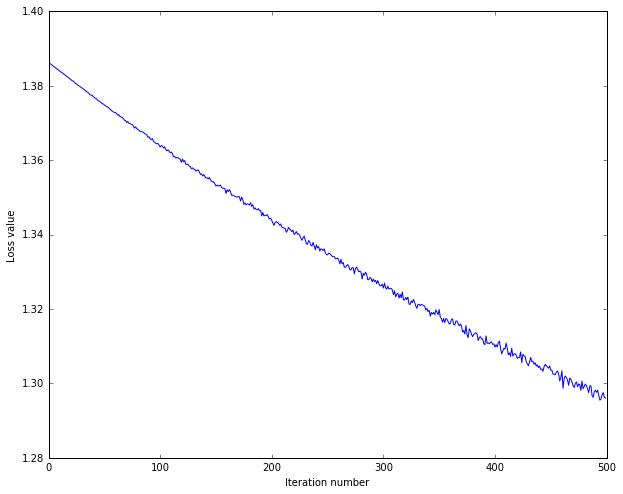

In [168]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')

In [170]:
y_train_pred = sm.predict(X_train)
y_test_pred = sm.predict(X_test)

In [171]:
print classification_report(y_test, y_test_pred)

             precision    recall  f1-score   support

          0       0.52      0.20      0.29     15609
          1       0.13      0.03      0.05      8811
          2       0.25      0.02      0.04     24281
          3       0.71      0.97      0.82    109036

avg / total       0.59      0.69      0.60    157737



In [172]:
# compare result with the most common dummy classifier
print classification_report(y_test, [3]*len(y_test))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00     15609
          1       0.00      0.00      0.00      8811
          2       0.00      0.00      0.00     24281
          3       0.69      1.00      0.82    109036

avg / total       0.48      0.69      0.57    157737



------

### 3. Kaggle In Class - 50 Баллов


Так как в качестве метрики используется logloss, то будем использовать softmax, так как он почти это выдает в качестве loss:

In [15]:
tic = time.time()

for batch_size in [2**x for x in range(10, 14)]:
    for reg in [1, 0.1, 0.01, 0.001, 0.0001]:
        for learning_rate in [10, 5, 1, 0.1, 0.01, 0.001]:
            sm = Softmax()
            loss_hist = sm.train(X_train, y_train, learning_rate=learning_rate, reg=reg,
                          num_iters=1000, verbose=False, batch_size=batch_size)
            print 'Batch size: %f, reg: %f, learning rate: %f loss: %f' % (batch_size, reg, learning_rate, 
                                                                           np.min(loss_hist[loss_hist > 0]))
                   
toc = time.time()
print 'That took %fs' % (toc - tic)

KeyboardInterrupt: 

In [ ]:
tic = time.time()

for batch_size in [2**x for x in range(11, 14)]:
    for reg in [1, 0.1, 0.01, 0.05, 0.001, 0.005, 0.0001]:
        for learning_rate in [30, 20, 10, 5, 1]:
            sm = Softmax()
            loss_hist = sm.train(X_train, y_train, learning_rate=learning_rate, reg=reg,
                          num_iters=1000, verbose=False, batch_size=batch_size)
            print 'Batch size: %f, reg: %f, learning rate: %f loss: %f' % (batch_size, reg, learning_rate, 
                                                                           np.min(loss_hist[loss_hist > 0]))
                   
toc = time.time()
print 'That took %fs' % (toc - tic)

------

### 4. Бонусы - 30 Баллов

Используем stop_words='english' и $l_2$ нормализацию в TF_IDF:

In [20]:
corpus = data.Reviews_Summary.values
vectorizer = CountVectorizer(min_df=1, max_features=3500, stop_words='english')
X = vectorizer.fit_transform(corpus)
transformer = TfidfTransformer(norm='l2')
X = transformer.fit_transform(X).toarray()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
X_train, X_test = X_train.T, X_test.T

In [42]:
sm = Softmax()
tic = time.time()
loss_hist = sm.train(X_train, y_train, learning_rate=7, reg=1,
                      num_iters=1000, verbose=True, batch_size=20000)
toc = time.time()
print 'That took %fs' % (toc - tic)
print 'Current loss is %f' % loss_hist[-1]

iteration 0 / 1000: loss 1.386268
iteration 100 / 1000: loss 1.386268
iteration 200 / 1000: loss 1.386268
iteration 300 / 1000: loss 1.386268
iteration 400 / 1000: loss 1.386268
iteration 500 / 1000: loss 1.386268
iteration 600 / 1000: loss 1.386268
iteration 700 / 1000: loss 1.386268
iteration 800 / 1000: loss 1.386268
iteration 900 / 1000: loss 1.386268
That took 252.451672s
Current loss is -391.906731


In [44]:
predict = sm.predict_prob(X_test)

In [45]:
from sklearn.metrics import log_loss
log_loss(y_test, predict)

ValueError: Found arrays with inconsistent numbers of samples: [     4 116252]

In [41]:
help(log_loss)

Help on function log_loss in module sklearn.metrics.classification:

log_loss(y_true, y_pred, eps=1e-15, normalize=True, sample_weight=None)
    Log loss, aka logistic loss or cross-entropy loss.
    
    This is the loss function used in (multinomial) logistic regression
    and extensions of it such as neural networks, defined as the negative
    log-likelihood of the true labels given a probabilistic classifier's
    predictions. For a single sample with true label yt in {0,1} and
    estimated probability yp that yt = 1, the log loss is
    
        -log P(yt|yp) = -(yt log(yp) + (1 - yt) log(1 - yp))
    
    Read more in the :ref:`User Guide <log_loss>`.
    
    Parameters
    ----------
    y_true : array-like or label indicator matrix
        Ground truth (correct) labels for n_samples samples.
    
    y_pred : array-like of float, shape = (n_samples, n_classes)
        Predicted probabilities, as returned by a classifier's
        predict_proba method.
    
    eps : float
 

In [ ]:
test_df = pd.read_csv('texts_data/test.csv', index_col=0, na_values='NaN')
corpus_test = test_df["Reviews_Summary"].values
test_vectorized = vectorizer.transform(corpus_test)
test_tfidf = transformer.transform(test_vectorized).toarray()
pred = sm.predict_prob(test_array.T)
results_matrix = pred.T
result = pd.DataFrame(test_df["Id"])

ans.index = ids_test
ans.index.name="Id"
ans.columns=["class_0", "class_1", "class_2", "class_3"]
ans.to_csv('kaggle_data/output.csv')